# (MBTI) Myers-Briggs Personality Type Prediction

* Extroversion vs. Introversion
    * I - 0
    * E - 1 
    
* Sensing vs. Intuition 
    * N - 0 
    * S - 1
    
* Thinking vs. Feeling
    * F - 0
    * T - 1
    
* Judging vs. Perceiving
    * P - 0
    * J - 1 
    
## IMPLEMENTING DIFFERENT MODELS 

In [24]:
# importing dependencies here
import numpy as np
import pandas as pd

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# data stratifying and splitting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# algorithms/models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import average_precision_score

# from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# (
#     classification_report,
#     f1_score,
#     accuracy_score,
#     roc_auc_score,
# )

# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# saving the model
from joblib import dump

# code formatter
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
# reading the final datasets
personality_data = pd.read_csv("data_ekta/clean_data_3.csv")

<IPython.core.display.Javascript object>

In [3]:
# checking counts dataset
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,compound_sentiment,pos_sentiment,neg_sentiment,...,em,colons,emojis,word_count,unique_words,post_length_var,upper,link_count,ellipses,img_count
0,INFJ,0,0,0,1,'When asked of the things you wish you did ear...,asked thing wish earlier find answering...,0.99980,0.414667,0.136150,...,0.22,0.32,0.08,30.98,14.92,78.414931,1.46,0.04,0.62,0.0
1,INFJ,0,0,0,1,'I love both and they are equally important to...,love equally important music window soul in...,0.99995,0.596000,0.134585,...,0.36,0.14,0.00,28.58,12.72,160.744400,1.62,0.02,0.04,0.0


<IPython.core.display.Javascript object>

### Setting predictors and target variable


In [4]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = personality_data[
    [
        "clean_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "qm",
        "em",
        "colons",
        "emojis",
        "word_count",
        "unique_words",
        "upper",
        "link_count",
        "ellipses",
        "img_count",
    ]
]

# setting y to four targets is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = personality_data.iloc[:, 1:5]

# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(8588, 22)
(8588, 4)


<IPython.core.display.Javascript object>

### Creating a list of words (other than the stop words) to be dropped to improve model performanace

In [5]:
additional_stopwords = [
    "hey",
    "hello",
    "briggs",
    "cat",
    "car",
    "mbti",
    "soup",
    "tea",
    "stuff",
    "gift",
    "song",
    "world",
    "type",
]

<IPython.core.display.Javascript object>

### Setting up preprocessor for vectorization and selecting best counts and scores

In [6]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_n_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colons",
    "emojis",
    "word_count",
    "unique_words",
    "upper",
    "link_count",
    "ellipses",
    "img_count",
]

# for selecting k best features from features other than words
best_k_features = make_pipeline(MinMaxScaler(), SelectKBest(f_classif, k=10))

# setting up preprocessing for TF-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

# setting up preprocessing for COUNT vectorizer
preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "ct_vect",
            CountVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

### Modelling

In [7]:
# setting up the personality dictionary for printing scores
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}

# function to build the model for predicting each of 4 target features
def build_model(model, X, y, vectorizer_name):

    for col in y.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )

        # model training
        model.fit(X_train, y_train)
        
        # y_hat
        y_pred = model.predict(X_test)
        
        # y_probability
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # precision recall score
        average_precision = average_precision_score(y_test, y_proba)

        # model evaluation
        print(f"Geometric Mean Score: {geometric_mean_score(y_test, y_pred, average='weighted'):.2f}")
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
        print(f"Average Precision-Recall Score: {average_precision:.2f}") 
        print(classification_report_imbalanced(y_test, y_pred))


<IPython.core.display.Javascript object>

### TF-IDF Logistic Regression

In [8]:
%%time

tfidf_logistic_regression = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(cv=10)
)
build_model(tfidf_logistic_regression, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.68
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.69      0.66      0.77      0.68      0.46      1322
          1       0.39      0.66      0.69      0.49      0.68      0.45       396

avg / total       0.76      0.68      0.67      0.71      0.68      0.46      1718


Sensing vs Intuition
Geometric Mean Score: 0.70
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.38
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.68      0.73      0.79      0.70      0.49      1481
          1       0.27      0.73      0.68      0.39      0.70      0.50       237

avg / total       0.85      0.69      0.72      0.73      0.70      0.49      1718


Thinking vs Feeling
Geometric Mean Score: 0.78
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

<IPython.core.display.Javascript object>

### Count Vectorized Logistic Regression

In [9]:
%%time
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(cv=10)
)
build_model(ct_logistic_regression, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.65
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.68      0.62      0.76      0.65      0.42      1322
          1       0.36      0.62      0.68      0.46      0.65      0.42       396

avg / total       0.74      0.66      0.63      0.69      0.65      0.42      1718


Sensing vs Intuition
Geometric Mean Score: 0.67
ROC-AUC Score: 0.73
Average Precision-Recall Score: 0.33
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.63      0.71      0.75      0.67      0.44      1481
          1       0.23      0.71      0.63      0.35      0.67      0.45       237

avg / total       0.84      0.64      0.70      0.70      0.67      0.44      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.82
           

<IPython.core.display.Javascript object>

### Cross Validated TF-IDF Logistic Lasso

In [10]:
%%time
tfidf_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(tfidf_logistic_regression_lasso, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.43
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.67      0.61      0.75      0.64      0.41      1322
          1       0.36      0.61      0.67      0.45      0.64      0.41       396

avg / total       0.74      0.66      0.63      0.68      0.64      0.41      1718


Sensing vs Intuition
Geometric Mean Score: 0.69
ROC-AUC Score: 0.73
Average Precision-Recall Score: 0.32
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.67      0.70      0.78      0.69      0.47      1481
          1       0.25      0.70      0.67      0.37      0.69      0.47       237

avg / total       0.84      0.68      0.70      0.72      0.69      0.47      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.81
           

<IPython.core.display.Javascript object>

### Cross Validated Count Vectorized Logistic Lasso

In [11]:
%%time
ct_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(ct_logistic_regression_lasso, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.65
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.38
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.65      0.64      0.74      0.65      0.42      1322
          1       0.36      0.64      0.65      0.46      0.65      0.42       396

avg / total       0.74      0.65      0.64      0.68      0.65      0.42      1718


Sensing vs Intuition
Geometric Mean Score: 0.63
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.28
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.62      0.63      0.74      0.63      0.39      1481
          1       0.21      0.63      0.62      0.32      0.63      0.39       237

avg / total       0.82      0.62      0.63      0.68      0.63      0.39      1718


Thinking vs Feeling
Geometric Mean Score: 0.75
ROC-AUC Score: 0.84
Average Precision-Recall Score: 0.80
           

<IPython.core.display.Javascript object>

### Cross Validated TF-IDF Logistic Ridge

In [12]:
%%time
tfidf_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(tfidf_logistic_regression_ridge, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.69
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.68      0.69      0.77      0.69      0.47      1322
          1       0.39      0.69      0.68      0.50      0.69      0.47       396

avg / total       0.77      0.68      0.69      0.71      0.69      0.47      1718


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.67      0.75      0.78      0.71      0.50      1481
          1       0.26      0.75      0.67      0.39      0.71      0.50       237

avg / total       0.85      0.68      0.74      0.73      0.71      0.50      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

<IPython.core.display.Javascript object>

### Cross Validated Count Vectorized Logistic Ridge

In [13]:
%%time
ct_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(ct_logistic_regression_ridge, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.66      0.62      0.75      0.64      0.41      1322
          1       0.36      0.62      0.66      0.45      0.64      0.41       396

avg / total       0.74      0.65      0.63      0.68      0.64      0.41      1718


Sensing vs Intuition
Geometric Mean Score: 0.66
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.32
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.65      0.66      0.76      0.66      0.43      1481
          1       0.23      0.66      0.65      0.34      0.66      0.43       237

avg / total       0.83      0.65      0.66      0.71      0.66      0.43      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.82
           

<IPython.core.display.Javascript object>

### TF-IDF Logistic Elasticnet

* Takes longest to run and the results are almost same as lasso and ridge model. So this code is commented to save time when re-running the entire notebook.

In [14]:
# %%time

# for col in y.columns:

#     print(f"\n{mbti_type[col]}")

#     target = y[col]

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, target, test_size=0.2, random_state=42, stratify=target
#     )

#     tfidf_logistic_regression_elasticnet = imb_make_pipeline(
#         preprocesser_tf,
#     #     DenseTransformer(),
#         RandomUnderSampler(),
#         LogisticRegressionCV(
#             penalty='elasticnet',
#             l1_ratios=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
#             solver='saga'
#         )
#     )

#     tfidf_logistic_regression_elasticnet.fit(X_train, y_train)

#     print(f'Accuracy: {tfidf_logistic_regression_elasticnet.score(X_test, y_test)} \n')
#     print(classification_report(y_test, tfidf_logistic_regression_elasticnet.predict(X_test)))

<IPython.core.display.Javascript object>

### TF-IDF Support Vector Classifier

In [25]:
%%time
tfidf_svc = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), DenseTransformer(), SVC(kernel='linear',probability=True)
)
build_model(tfidf_svc, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.68
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.45
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.67      0.69      0.76      0.68      0.47      1322
          1       0.39      0.69      0.67      0.50      0.68      0.47       396

avg / total       0.77      0.68      0.69      0.70      0.68      0.47      1718


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.77
Average Precision-Recall Score: 0.38
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.68      0.73      0.79      0.71      0.49      1481
          1       0.27      0.73      0.68      0.39      0.71      0.50       237

avg / total       0.85      0.69      0.73      0.73      0.71      0.50      1718


Thinking vs Feeling
Geometric Mean Score: 0.78
ROC-AUC Score: 0.86
Average Precision-Recall Score: 0.83
           

<IPython.core.display.Javascript object>

### Count Vectorized Support Vector Classifier

In [26]:
%%time
ct_svc = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), SVC(kernel='linear',probability=True)
)
build_model(ct_svc, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.63
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.36
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.62      0.64      0.72      0.63      0.39      1322
          1       0.33      0.64      0.62      0.44      0.63      0.39       396

avg / total       0.73      0.62      0.63      0.65      0.63      0.39      1718


Sensing vs Intuition
Geometric Mean Score: 0.63
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.27
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.61      0.66      0.73      0.63      0.40      1481
          1       0.21      0.66      0.61      0.32      0.63      0.40       237

avg / total       0.82      0.61      0.65      0.67      0.63      0.40      1718


Thinking vs Feeling
Geometric Mean Score: 0.72
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.75
           

<IPython.core.display.Javascript object>

### TF-IDF Naive Bayes

In [17]:
%%time
tfidf_nb = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(tfidf_nb, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.70
ROC-AUC Score: 0.76
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.64      0.75      0.75      0.69      0.48      1322
          1       0.39      0.75      0.64      0.51      0.69      0.49       396

avg / total       0.78      0.67      0.73      0.69      0.69      0.48      1718


Sensing vs Intuition
Geometric Mean Score: 0.70
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.41
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.67      0.73      0.78      0.70      0.48      1481
          1       0.26      0.73      0.67      0.38      0.70      0.49       237

avg / total       0.84      0.68      0.72      0.72      0.70      0.48      1718


Thinking vs Feeling
Geometric Mean Score: 0.76
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.81
           

<IPython.core.display.Javascript object>

### Count Vectorized Naive Bayes

In [18]:
%%time
ct_nb = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(ct_nb, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.69
ROC-AUC Score: 0.76
Average Precision-Recall Score: 0.44
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.66      0.72      0.76      0.69      0.48      1322
          1       0.39      0.72      0.66      0.51      0.69      0.48       396

avg / total       0.77      0.68      0.71      0.70      0.69      0.48      1718


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.37
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.68      0.74      0.79      0.71      0.50      1481
          1       0.27      0.74      0.68      0.40      0.71      0.51       237

avg / total       0.85      0.69      0.73      0.74      0.71      0.50      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.79
           

<IPython.core.display.Javascript object>

### Count Vectorized Random Forest

In [19]:
%%time
ct_rf = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(ct_rf, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.43
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.66      0.63      0.74      0.64      0.41      1322
          1       0.35      0.63      0.66      0.45      0.64      0.41       396

avg / total       0.74      0.65      0.64      0.68      0.64      0.41      1718


Sensing vs Intuition
Geometric Mean Score: 0.64
ROC-AUC Score: 0.69
Average Precision-Recall Score: 0.26
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.62      0.66      0.74      0.64      0.41      1481
          1       0.22      0.66      0.62      0.33      0.64      0.41       237

avg / total       0.82      0.62      0.66      0.68      0.64      0.41      1718


Thinking vs Feeling
Geometric Mean Score: 0.73
ROC-AUC Score: 0.81
Average Precision-Recall Score: 0.76
           

<IPython.core.display.Javascript object>

### TF-IDF Random Forest

In [20]:
%%time
tfidf_rf = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(),
        RandomUnderSampler(),
        RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(tfidf_rf, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.69
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.65      0.63      0.74      0.64      0.41      1322
          1       0.35      0.63      0.65      0.45      0.64      0.41       396

avg / total       0.74      0.64      0.63      0.67      0.64      0.41      1718


Sensing vs Intuition
Geometric Mean Score: 0.62
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.27
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.61      0.64      0.73      0.62      0.39      1481
          1       0.21      0.64      0.61      0.31      0.62      0.39       237

avg / total       0.82      0.61      0.63      0.67      0.62      0.39      1718


Thinking vs Feeling
Geometric Mean Score: 0.75
ROC-AUC Score: 0.81
Average Precision-Recall Score: 0.76
           

<IPython.core.display.Javascript object>

### TF-IDF KNN Classifier

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
tfidf_knn = imb_make_pipeline(
        preprocesser_tf, 
#         DenseTransformer(),
        RandomUnderSampler(),
        KNeighborsClassifier(n_neighbors=3),
)
build_model(tfidf_knn, X, y, "tfidf")

### Final Model - Logistic Regression with TF-IDF Vectorization

Selecting Logistic Regression as our final model as it returned the highest accuracy, precision and recall values as compared to other models.


Extrovert vs Introvert
                 coef
word                 
fun          3.702213
bored        3.366860
guy          3.146178
awesome      2.541361
ego          2.464928
family      -2.376884
inferior    -2.337102
instinctual  2.304210
dream       -2.303701
government  -2.265620
cold        -2.260137
developed    2.206144
debate       2.133905
game        -2.118911
friend       2.108427
charming     2.075628
feel        -2.042298
business     2.038443
dated        2.029189
earth       -2.015034
wish        -2.009695

Sensing vs Intuition
               coef
word               
rant       2.957881
human     -2.631082
idea      -2.556673
writing   -2.143060
shall     -2.099717
sound      2.019031
action     1.994066
inferior   1.989839
rave       1.950706
thanks     1.939405
woman     -1.927995
dark      -1.915258
anything   1.895240
teddy      1.893220
fun        1.886054
history   -1.849248
proud     -1.833090
thought   -1.823275
romance   -1.767409
running    1.758110
somethin

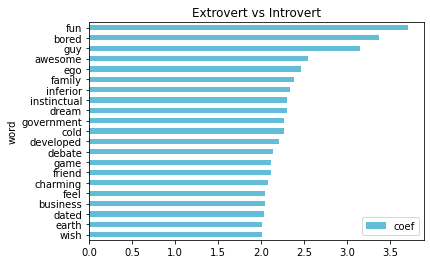

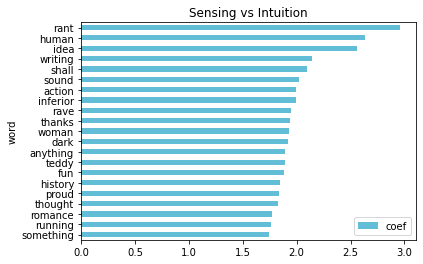

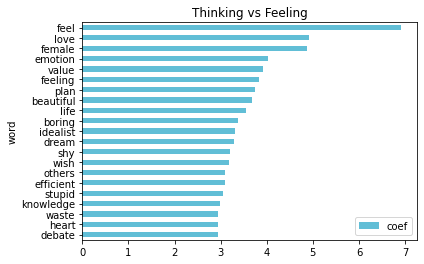

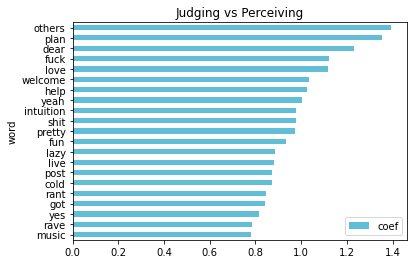

<IPython.core.display.Javascript object>

In [21]:
%%time

for col in y.columns:
    
    print(f"\n{mbti_type[col]}")

    target = y[col]

    tfidf_logistic_regression = imb_make_pipeline(
        preprocesser_tf,
        RandomUnderSampler(),
        LogisticRegressionCV()
    )
    
    # training the data on entire dataset
    tfidf_logistic_regression.fit(X, target)
    
    # feature importance   
    coef = tfidf_logistic_regression[-1].coef_[0]  
    word = tfidf_logistic_regression[0].named_transformers_["tfidf"].get_feature_names()
    word_list = list(zip(word, coef))         
    result = pd.DataFrame(word_list, columns=["word", "coef"]).set_index("word")    
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting feature importance
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])
  
    # saving the model
    dump(tfidf_logistic_regression, f"clf_{col}.joblib")